In [1]:
import pandas as pd
import numpy as np
from numpy import save, load
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

import time

In [2]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

## 1) Read in the Data

In [42]:
ratings = pd.read_csv('datasets/ratings.csv').drop(columns='timestamp')

print(ratings.info())
print(ratings.shape)
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10747027 entries, 0 to 10747026
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 246.0 MB
None
(10747027, 3)


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [43]:
ratings['userId'].unique().shape

(110490,)

In [44]:
ratings['userId'].describe()

count    1.074703e+07
mean     5.527060e+04
std      3.199301e+04
min      1.000000e+00
25%      2.774100e+04
50%      5.529900e+04
75%      8.292200e+04
max      1.104900e+05
Name: userId, dtype: float64

In [45]:
## Too much data - workbook runs out of memory - filter down to just first 50,000 users

ratings = ratings[ratings['userId'] <= 50000]

In [46]:
ratings['userId'].unique().shape

(50000,)

In [47]:
ratings['movieId'].unique().shape

(33318,)

In [48]:
# Clearly, all ratings are > 0; so we can use a rating of 0 to denote "User has not rated this movie"

ratings['rating'].value_counts()

4.0    1301558
3.0     961107
5.0     725005
3.5     589877
4.5     420238
2.0     324446
2.5     238029
1.0     154229
0.5      81636
1.5      77412
Name: rating, dtype: int64

In [49]:
ratings['userId'].value_counts(ascending=True)

25158       1
18420       1
42703       1
47460       1
27722       1
         ... 
11109    3732
7705     4546
4796     4874
37046    5041
48470    5257
Name: userId, Length: 50000, dtype: int64

## 2) Create a Users-Ratings Matrix

In [50]:
users_ratings_matrix = pd.DataFrame(data=np.zeros(shape=(ratings['userId'].unique().shape[0],
                                                         ratings['movieId'].unique().shape[0])),
                                    index=ratings['userId'].unique(),
                                    columns=ratings['movieId'].unique())

print(users_ratings_matrix.shape)
users_ratings_matrix.head()

(50000, 33318)


,307,481,1091,1257,1449,1590,1591,2134,2478,2840,2986,3020,3424,3698,3826,3893,170,849,1186,1235,1244,1296,1663,1962,2108,2243,2352,2707,2746,2915,3363,640,828,960,1221,1321,1645,1825,1985,2024,2028,3171,1,2,5,6,10,11,16,19,20,23,25,31,32,34,36,39,41,44,45,47,50,61,62,65,66,70,76,85,95,100,104,110,141,145,150,151,153,158,160,161,163,165,169,172,173,175,180,181,185,186,193,198,204,216,223,231,253,255,...,158549,158551,162046,181547,187161,152218,152220,189879,129227,132184,149332,151503,160830,162450,170699,171671,172935,176803,179153,192013,109862,141698,150318,109241,125245,139755,139823,161610,170743,174921,177459,96894,154902,154904,154906,154911,156896,71755,137799,150939,157367,161928,165147,169502,170655,170657,96148,124304,130572,145743,124633,135049,145208,108989,111797,114261,149745,169480,173437,184123,188569,189727,191867,32485,96218,118464,73154,147986,134781,176639,176641,176645,176647,176649,176651,176653,128316,142272,122938,141179,159233,159239,162424,134113,3332,152187,84863,99564,105490,105972,110537,111915,112650,118816,123316,123467,124224,130233,137463,139717
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [24]:
start = time.time()

for n, row in users_ratings_matrix.iterrows():
    temp = ratings[ratings['userId'] == n]
    for id in temp['movieId']:
        users_ratings_matrix.loc[n, id] = temp[temp['movieId'] == id]['rating'].values[0]
        
end = time.time()

In [25]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 1720.4560871124268


In [26]:
users_ratings_matrix.head()

,307,481,1091,1257,1449,1590,1591,2134,2478,2840,2986,3020,3424,3698,3826,3893,170,849,1186,1235,1244,1296,1663,1962,2108,2243,2352,2707,2746,2915,3363,640,828,960,1221,1321,1645,1825,1985,2024,2028,3171,1,2,5,6,10,11,16,19,20,23,25,31,32,34,36,39,41,44,45,47,50,61,62,65,66,70,76,85,95,100,104,110,141,145,150,151,153,158,160,161,163,165,169,172,173,175,180,181,185,186,193,198,204,216,223,231,253,255,...,158549,158551,162046,181547,187161,152218,152220,189879,129227,132184,149332,151503,160830,162450,170699,171671,172935,176803,179153,192013,109862,141698,150318,109241,125245,139755,139823,161610,170743,174921,177459,96894,154902,154904,154906,154911,156896,71755,137799,150939,157367,161928,165147,169502,170655,170657,96148,124304,130572,145743,124633,135049,145208,108989,111797,114261,149745,169480,173437,184123,188569,189727,191867,32485,96218,118464,73154,147986,134781,176639,176641,176645,176647,176649,176651,176653,128316,142272,122938,141179,159233,159239,162424,134113,3332,152187,84863,99564,105490,105972,110537,111915,112650,118816,123316,123467,124224,130233,137463,139717
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,3.5,3.0,3.0,4.5,3.0,4.0,3.5,4.5,4.0,3.5,4.0,3.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,2.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.0,1.0,0.0,0.0,3.5,3.5,0.0,3.0,3.5,1.5,3.5,0.0,4.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,5.0,0.0,4.0,4.0,2.0,4.5,4.0,3.5,4.0,2.0,2.5,3.0,4.5,3.0,4.5,3.5,3.5,2.5,4.5,1.0,2.0,5.0,4.5,3.0,3.5,0.5,0.5,3.0,2.0,4.0,4.5,4.0,3.0,4.5,4.5,4.0,4.0,4.5,2.0,0.5,2.5,4.0,2.5,4.5,0.5,3.5,3.5,3.5,4.5,0.5,3.0,2.0,0.5,4.5,3.5,2.0,4.5,0.5,4.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [27]:
users_ratings_matrix.tail()

,307,481,1091,1257,1449,1590,1591,2134,2478,2840,2986,3020,3424,3698,3826,3893,170,849,1186,1235,1244,1296,1663,1962,2108,2243,2352,2707,2746,2915,3363,640,828,960,1221,1321,1645,1825,1985,2024,2028,3171,1,2,5,6,10,11,16,19,20,23,25,31,32,34,36,39,41,44,45,47,50,61,62,65,66,70,76,85,95,100,104,110,141,145,150,151,153,158,160,161,163,165,169,172,173,175,180,181,185,186,193,198,204,216,223,231,253,255,...,158549,158551,162046,181547,187161,152218,152220,189879,129227,132184,149332,151503,160830,162450,170699,171671,172935,176803,179153,192013,109862,141698,150318,109241,125245,139755,139823,161610,170743,174921,177459,96894,154902,154904,154906,154911,156896,71755,137799,150939,157367,161928,165147,169502,170655,170657,96148,124304,130572,145743,124633,135049,145208,108989,111797,114261,149745,169480,173437,184123,188569,189727,191867,32485,96218,118464,73154,147986,134781,176639,176641,176645,176647,176649,176651,176653,128316,142272,122938,141179,159233,159239,162424,134113,3332,152187,84863,99564,105490,105972,110537,111915,112650,118816,123316,123467,124224,130233,137463,139717
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,5.0,0.0,0.0,4.0,3.0,5.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [52]:
movie_ids = users_ratings_matrix.columns

X = users_ratings_matrix.to_numpy()
del users_ratings_matrix

In [29]:
save('user_ratings_matrix.npy', X)

In [55]:
save('movie_ids.npy', movie_ids)

## 3) Dimension-Reduce the Matrix

In [5]:
X = load('user_ratings_matrix.npy')

In [6]:
start = time.time()

svd = TruncatedSVD(n_components=700, n_iter=20, random_state=42)
svd.fit(X.T)

end = time.time()

In [7]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 14.51 minutes


In [8]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.17350683 0.03749056 0.02233363 0.0174791  0.01329873 0.01141459
 0.01075951 0.00789823 0.00685285 0.00613391 0.00535015 0.00502308
 0.0047046  0.00432624 0.00381093 0.00371747 0.00347588 0.00341642
 0.00320791 0.00306771 0.0028575  0.00276611 0.00263415 0.0024855
 0.00244975 0.0023544  0.00227678 0.0022257  0.0021908  0.00214666
 0.00204237 0.00198858 0.00192086 0.00186623 0.00185666 0.00179268
 0.00175677 0.00168654 0.00167421 0.00164942 0.00161431 0.00157936
 0.0015642  0.00151183 0.00149304 0.00145435 0.00145094 0.00141785
 0.00140073 0.00138    0.00135923 0.00133425 0.00132339 0.00129857
 0.00128943 0.00127183 0.00126823 0.00125294 0.00122775 0.00122736
 0.00119637 0.00119021 0.00117461 0.00117011 0.00115583 0.00113631
 0.00112939 0.00111682 0.0011063  0.00110109 0.00108425 0.00107619
 0.00106054 0.00105148 0.00104456 0.0010411  0.00101512 0.00101178
 0.00100488 0.0010019  0.00099726 0.00098809 0.00098245 0.00097571
 0.00095569 0.00094443 0.00093856 0.00093281 0.00092569 0.00092

In [9]:
svd.components_.T.shape

(50000, 700)

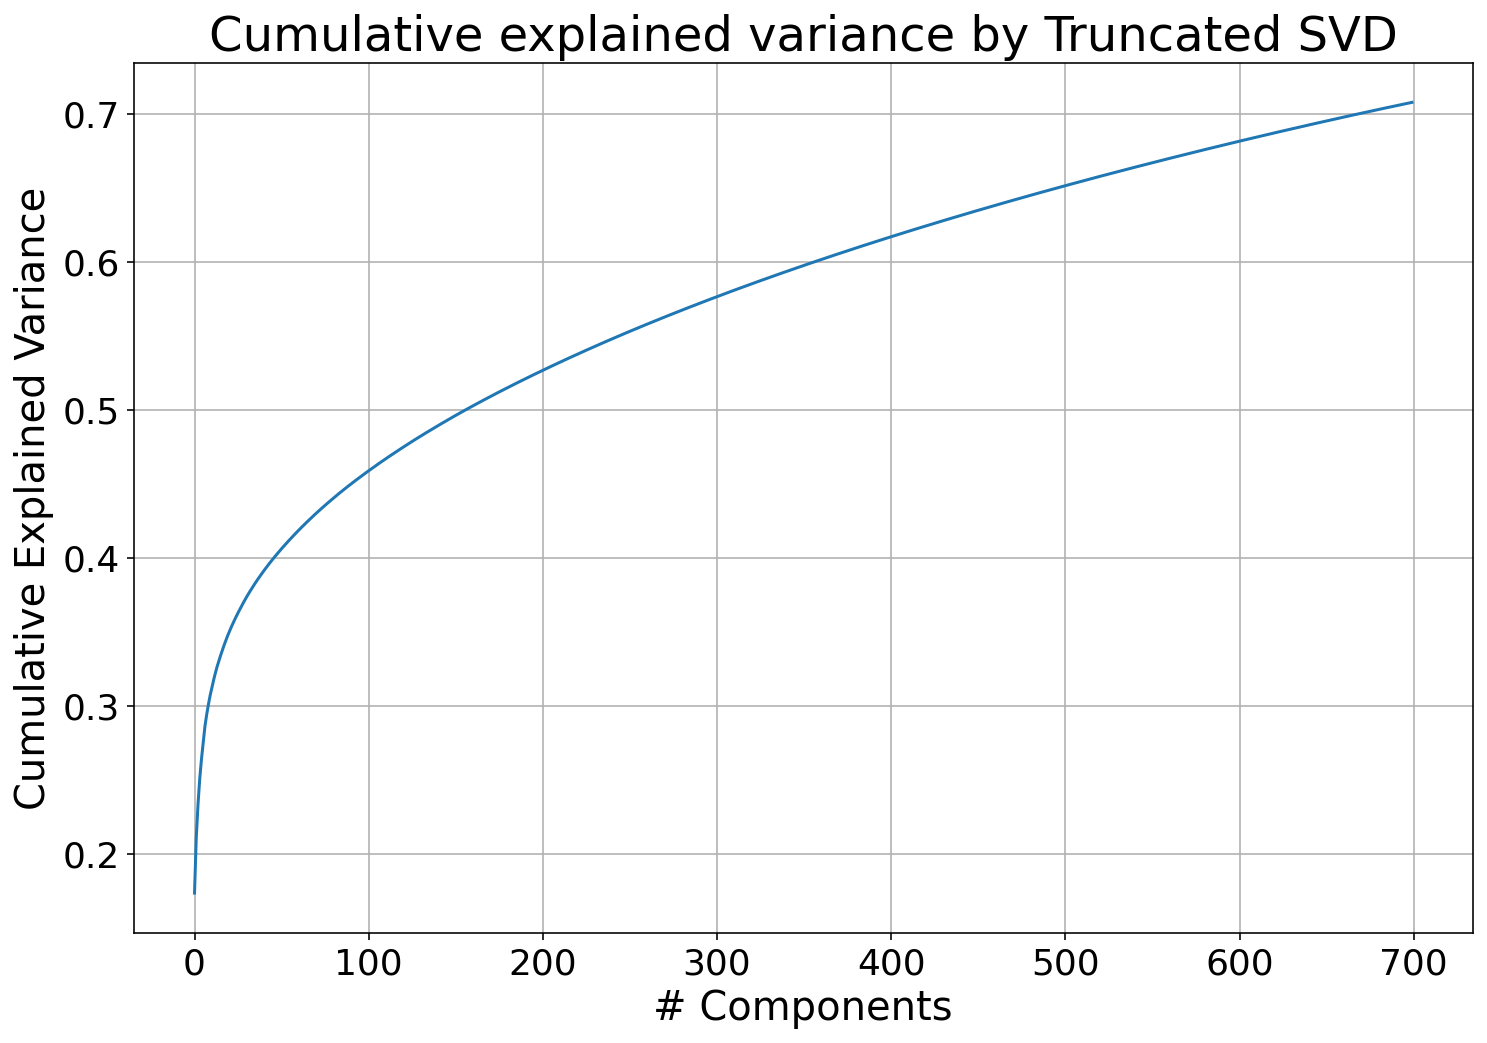

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [11]:
del X

In [13]:
# mat = pd.DataFrame(data=svd.components_.T, index=np.linspace(1, 50000, num=50000, dtype=int))
# mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699
1,-1.391523e-30,-4.715883e-17,-4.969275e-16,-1.632914e-15,-1.740542e-16,-4.257286e-16,4.799917e-17,-7.538882e-16,-9.236991e-16,-8.095296e-17,-4.490593e-18,-4.079968e-15,3.305958e-16,-1.310349e-15,-3.639043e-15,-6.392493e-15,-1.487719e-15,-5.856146e-15,-6.492297e-15,6.116114e-16,-2.109178e-15,-6.950993e-15,-4.108992e-15,7.013141e-15,-2.882642e-15,-6.373640e-15,-1.137041e-14,-1.431832e-15,1.136339e-14,-4.249977e-16,1.144675e-14,-8.644968e-15,-2.260181e-16,-8.267834e-15,-9.778590e-15,-1.198506e-14,-4.653125e-15,-1.385235e-14,-1.218352e-15,-1.819467e-15,1.219021e-14,8.855820e-15,-7.406910e-16,-2.649482e-15,-9.009914e-15,2.936793e-14,-1.038880e-14,8.062274e-16,3.446548e-15,1.003429e-14,-1.553847e-15,-9.320298e-16,2.377849e-14,-2.740076e-15,2.064127e-14,1.269913e-14,5.673771e-15,4.880346e-15,6.186108e-15,-2.348429e-14,3.149290e-14,-2.233164e-14,2.167106e-15,2.838639e-14,1.302920e-14,7.386731e-15,7.091875e-15,-5.313068e-15,-5.513653e-15,-1.562246e-14,-2.215766e-14,-9.273185e-15,-1.257440e-15,-3.311862e-14,-1.631509e-14,1.663032e-14,2.663252e-14,-7.627808e-15,1.163464e-14,1.969792e-14,1.753494e-15,-2.123148e-14,1.647154e-14,-7.037514e-15,-3.638224e-14,5.834199e-15,3.514263e-15,-1.367790e-15,-6.770512e-15,7.314443e-15,4.742345e-15,-4.033966e-15,7.546933e-16,5.214054e-16,2.050279e-14,2.165122e-14,1.466484e-14,-4.134650e-15,-1.687024e-14,2.114238e-14,...,-3.549502e-15,-1.622361e-14,5.477746e-14,-1.897614e-14,-5.892929e-14,-8.196721e-14,2.723244e-14,-4.363233e-14,8.715240e-14,-6.744672e-15,-1.402948e-13,-1.243315e-13,5.833497e-14,-5.801889e-14,5.386905e-14,-2.755668e-14,1.094936e-13,-2.343153e-15,-7.807730e-14,3.114158e-14,-3.510637e-14,-8.114390e-14,-2.103269e-14,6.773253e-14,2.911808e-14,9.122020e-15,-8.151062e-14,2.994783e-14,-8.071536e-14,-3.135985e-14,6.007922e-14,8.137489e-14,-2.155230e-14,6.059981e-14,7.273785e-14,-3.819320e-14,-3.987613e-14,-7.035342e-14,-1.171029e-14,-5.914719e-14,-1.864164e-14,-1.252505e-14,2.944156e-15,1.797039e-15,-8.596033e-14,-1.914953e-13,-1.080562e-14,4.610798e-14,5.774636e-14,2.898869e-14,-7.415826e-14,-5.975895e-14,-3.047597e-14,2.645581e-14,3.021626e-14,2.804123e-14,-1.336673e-13,5.537996e-15,8.123085e-14,-5.447831e-14,-2.220857e-14,3.688620e-14,-1.211071e-13,3.891365e-14,9.450869e-15,-7.853574e-14,5.500301e-14,2.286645e-14,-1.592177e-14,3.034841e-14,-2.397547e-14,2.348901e-14,-4.040890e-15,-2.620176e-14,2.398122e-14,-2.628011e-14,1.959632e-14,4.129148e-14,2.979967e-15,1.692097e-14,8.560655e-14,-2.662609e-14,-6.884778e-14,4.758137e-14,1.089302e-13,6.182798e-14,1.036290e-13,-2.862800e-14,4.066832e-14,-2.596866e-14,-2.141088e-14,9.364970e-14,9.114695e-14,3.272227e-14,5.950138e-14,3.170713e-14,-1.261632e-13,1.736636e-13,-1.467114e-14,-8.821344e-14
2,2.199924e-04,-6.721331e-04,-9.154188e-04,-1.825798e-04,-6.240476e-04,7.338657e-04,-6.942314e-07,7.757937e-04,-1.573777e-05,-9.681310e-04,5.333862e-04,-4.073167e-04,-1.342840e-03,-6.418229e-04,-9.281368e-04,4.898468e-04,5.547954e-04,-2.094874e-03,5.683043e-04,4.222969e-04,1.827117e-03,2.844999e-04,1.446172e-03,7.979337e-04,-3.932205e-05,-1.632215e-03,-2.157636e-04,-1.439060e-03,-4.454984e-04,1.242873e-03,3.541167e-04,4.477976e-04,-5.890357e-04,4.945751e-04,2.450703e-03,-6.868224e-04,3.611703e-03,-1.574098e-03,-3.336317e-04,-1.271293e-03,-2.145179e-04,-9.632571e-04,-1.698618e-03,3.

In [14]:
# start = time.time()

# cosine_sim = cosine_similarity(mat, mat)

# end = time.time()

In [15]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 88.79 minutes


In [16]:
del mat
print(cosine_sim.shape)
cosine_sim

(50000, 50000)


array([[ 1.        , -0.00587294,  0.01432276, ...,  0.01825213,
        -0.04375423,  0.03563275],
       [-0.00587294,  1.        , -0.01500712, ..., -0.00847169,
        -0.022149  ,  0.00925859],
       [ 0.01432276, -0.01500712,  1.        , ...,  0.00516529,
        -0.01374299, -0.00784659],
       ...,
       [ 0.01825213, -0.00847169,  0.00516529, ...,  1.        ,
         0.00500998,  0.00137204],
       [-0.04375423, -0.022149  , -0.01374299, ...,  0.00500998,
         1.        ,  0.10172051],
       [ 0.03563275,  0.00925859, -0.00784659, ...,  0.00137204,
         0.10172051,  1.        ]])

In [17]:
# save('collaborative_cosine_sim.npy', cosine_sim)

In [6]:
start = time.time()

U, Sigma, VT = randomized_svd(X, 
                              n_components=700,
                              n_iter=20,
                              random_state=42)

end = time.time()

In [7]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 13.51 minutes


In [11]:
save('u_matrix.npy', U)

In [12]:
save('vt_matrix.npy', VT)

In [13]:
del U
del Sigma
del VT

## 4) Recommender

In [14]:
U = load('u_matrix.npy')
U.shape

(50000, 700)

In [15]:
X.shape

(50000, 33318)

In [56]:
movie_ids = load('movie_ids.npy')
movie_ids.shape

(33318,)

In [79]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)[['movieId', 'title']]
print(movies.shape)
movies.head()

(47723, 2)


,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [22]:
# cosine_sim = load('collaborative_cosine_sim.npy')

In [84]:
# Based on Recommender Systems Lecture 5

def user_rec(user_id, U, user_ratings_matrix, movie_ids, movies, min_rating=4, how_many=10):
    users = []
    # Calculate relative similarity with all other users
    for idx in range(U.shape[0]):
        if idx != user_id - 1:
            sim = np.dot(U[idx, :], U[user_id - 1, :])
            users.append((idx, sim))
            
    # Sort by degree of similarity and return top user
    users.sort(key=lambda x: x[1], reverse=True)
    top_user_id = users[0][0] + 1
    
    # Compare rated/unrated movies and return user_id's unrated movies from top_user_id's rated movies
#     comp = (user_ratings_matrix[user_id - 1] < full_mat.iloc[top_user]
    recs = movie_ids[[n for n,val in enumerate(X[user_id - 1]) \
                                    if n in np.where(X[top_user_id - 1] >= min_rating)[0] and val == 0]][0:how_many]
    print('Movies Recommended by Other Users Based on Your Viewing History:')
    return (top_user_id, movies[movies['movieId'].isin(recs)])

In [90]:
user_rec(1, U, X, movie_ids, movies, min_rating=5)

Movies Recommended by Other Users Based on Your Viewing History:


(38337,
       movieId                  title
 5           6                   Heat
 31         32         Twelve Monkeys
 33         34                   Babe
 46         47                  Se7en
 49         50     The Usual Suspects
 288       296           Pulp Fiction
 525       541           Blade Runner
 588       608                  Fargo
 864       924  2001: A Space Odyssey
 3157     3363      American Graffiti)

In [92]:
user_rec(4, U, X, movie_ids, movies, min_rating=4)

Movies Recommended by Other Users Based on Your Viewing History:


(45140,
       movieId                            title
 1107     1193  One Flew Over the Cuckoo's Nest
 1125     1213                       GoodFellas
 1166     1257               Better Off Dead...
 1225     1321   An American Werewolf in London
 1529     1663                          Stripes
 1933     2108                       L.A. Story
 1959     2134                    Weird Science
 2303     2485                   She's All That
 2723     2915                   Risky Business
 2983     3178                    The Hurricane)